In [1]:
import collections 
import copy 
import csv 
import os 
import modeling 
import optimization 
import tokenization 
import tensorflow as tf
import six
import math

print(os.getcwd())

/home/santhosh/Desktop/CS7016/mbert-tdl/bert-master


In [2]:
init_checkpoint = "./../multi_cased_L-12_H-768_A-12/bert_model.ckpt"

In [3]:
vars = tf.train.list_variables(init_checkpoint)
vars

[('bert/embeddings/LayerNorm/beta', [768]),
 ('bert/embeddings/LayerNorm/gamma', [768]),
 ('bert/embeddings/position_embeddings', [512, 768]),
 ('bert/embeddings/token_type_embeddings', [2, 768]),
 ('bert/embeddings/word_embeddings', [119547, 768]),
 ('bert/encoder/layer_0/attention/output/LayerNorm/beta', [768]),
 ('bert/encoder/layer_0/attention/output/LayerNorm/gamma', [768]),
 ('bert/encoder/layer_0/attention/output/dense/bias', [768]),
 ('bert/encoder/layer_0/attention/output/dense/kernel', [768, 768]),
 ('bert/encoder/layer_0/attention/self/key/bias', [768]),
 ('bert/encoder/layer_0/attention/self/key/kernel', [768, 768]),
 ('bert/encoder/layer_0/attention/self/query/bias', [768]),
 ('bert/encoder/layer_0/attention/self/query/kernel', [768, 768]),
 ('bert/encoder/layer_0/attention/self/value/bias', [768]),
 ('bert/encoder/layer_0/attention/self/value/kernel', [768, 768]),
 ('bert/encoder/layer_0/intermediate/dense/bias', [3072]),
 ('bert/encoder/layer_0/intermediate/dense/kernel'

In [4]:
class InputExample(object):
  """A single training/test example for simple sequence classification."""

  def __init__(self, guid, text_a, text_b=None, label=None):
    """Constructs a InputExample.

    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    self.guid = guid
    self.text_a = text_a
    self.text_b = text_b
    self.label = label


class PaddingInputExample(object):
  """Fake example so the num input examples is a multiple of the batch size.

  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.

  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """


class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example


class DataProcessor(object):
  """Base class for data converters for sequence classification data sets."""

  def get_train_examples(self, data_dir):
    """Gets a collection of `InputExample`s for the train set."""
    raise NotImplementedError()

  def get_dev_examples(self, data_dir):
    """Gets a collection of `InputExample`s for the dev set."""
    raise NotImplementedError()

  def get_test_examples(self, data_dir):
    """Gets a collection of `InputExample`s for prediction."""
    raise NotImplementedError()

  def get_labels(self):
    """Gets the list of labels for this data set."""
    raise NotImplementedError()

  @classmethod
  def _read_tsv(cls, input_file, quotechar=None):
    """Reads a tab separated value file."""
    with tf.gfile.Open(input_file, "r") as f:
      reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
      lines = []
      for line in reader:
        lines.append(line)
      return lines

In [5]:
class MrpcProcessor(DataProcessor):
  """Processor for the MRPC data set (GLUE version)."""

  def get_train_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

  def get_dev_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

  def get_test_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

  def get_labels(self):
    """See base class."""
    return ["0", "1"]

  def _create_examples(self, lines, set_type):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, line) in enumerate(lines):
      if i == 0:
        continue
      guid = "%s-%s" % (set_type, i)
      text_a = tokenization.convert_to_unicode(line[3])
      text_b = tokenization.convert_to_unicode(line[4])
      if set_type == "test":
        label = "0"
      else:
        label = tokenization.convert_to_unicode(line[0])
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    return examples

In [6]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
  """Truncates a sequence pair in place to the maximum length."""

  # This is a simple heuristic which will always truncate the longer sequence
  # one token at a time. This makes more sense than truncating an equal percent
  # of tokens from each, since if one sequence is very short then each token
  # that's truncated likely contains more information than a longer sequence.
  while True:
    total_length = len(tokens_a) + len(tokens_b)
    if total_length <= max_length:
      break
    if len(tokens_a) > len(tokens_b):
      tokens_a.pop()
    else:
      tokens_b.pop()

In [7]:
def convert_single_example(ex_index, example, label_list, max_seq_length,
                           tokenizer):
  """Converts a single `InputExample` into a single `InputFeatures`."""

  if isinstance(example, PaddingInputExample):
    return InputFeatures(
        input_ids=[0] * max_seq_length,
        input_mask=[0] * max_seq_length,
        segment_ids=[0] * max_seq_length,
        label_id=0,
        is_real_example=False), None

  label_map = {}
  for (i, label) in enumerate(label_list):
    label_map[label] = i

  tokens_a = tokenizer.tokenize(example.text_a)
  tokens_b = None
  if example.text_b:
    tokens_b = tokenizer.tokenize(example.text_b)

  if tokens_b:
    # Modifies `tokens_a` and `tokens_b` in place so that the total
    # length is less than the specified length.
    # Account for [CLS], [SEP], [SEP] with "- 3"
    _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
  else:
    # Account for [CLS] and [SEP] with "- 2"
    if len(tokens_a) > max_seq_length - 2:
      tokens_a = tokens_a[0:(max_seq_length - 2)]

  # The convention in BERT is:
  # (a) For sequence pairs:
  #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
  #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
  # (b) For single sequences:
  #  tokens:   [CLS] the dog is hairy . [SEP]
  #  type_ids: 0     0   0   0  0     0 0
  #
  # Where "type_ids" are used to indicate whether this is the first
  # sequence or the second sequence. The embedding vectors for `type=0` and
  # `type=1` were learned during pre-training and are added to the wordpiece
  # embedding vector (and position vector). This is not *strictly* necessary
  # since the [SEP] token unambiguously separates the sequences, but it makes
  # it easier for the model to learn the concept of sequences.
  #
  # For classification tasks, the first vector (corresponding to [CLS]) is
  # used as the "sentence vector". Note that this only makes sense because
  # the entire model is fine-tuned.
  tokens = []
  segment_ids = []
  tokens.append("[CLS]")
  segment_ids.append(0)
  for token in tokens_a:
    tokens.append(token)
    segment_ids.append(0)
  tokens.append("[SEP]")
  segment_ids.append(0)

  if tokens_b:
    for token in tokens_b:
      tokens.append(token)
      segment_ids.append(1)
    tokens.append("[SEP]")
    segment_ids.append(1)

  input_ids = tokenizer.convert_tokens_to_ids(tokens)

  # The mask has 1 for real tokens and 0 for padding tokens. Only real
  # tokens are attended to.
  input_mask = [1] * len(input_ids)

  # Zero-pad up to the sequence length.
  while len(input_ids) < max_seq_length:
    input_ids.append(0)
    input_mask.append(0)
    segment_ids.append(0)

  assert len(input_ids) == max_seq_length
  assert len(input_mask) == max_seq_length
  assert len(segment_ids) == max_seq_length

  label_id = label_map[example.label]
  if ex_index < 5:
    tf.logging.info("*** Example ***")
    tf.logging.info("guid: %s" % (example.guid))
    tf.logging.info("tokens: %s" % " ".join(
        [tokenization.printable_text(x) for x in tokens]))
    tf.logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
    tf.logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
    tf.logging.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
    tf.logging.info("label: %s (id = %d)" % (example.label, label_id))

  feature = InputFeatures(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids,
      label_id=label_id,
      is_real_example=True)
  return feature, tokens

In [8]:
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer):
  """Convert a set of `InputExample`s to a list of `InputFeatures`."""

  features = []
  token_list = []
  for (ex_index, example) in enumerate(examples):
    if ex_index % 10000 == 0:
      tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))

    feature, token = convert_single_example(ex_index, example, label_list,
                                     max_seq_length, tokenizer)

    features.append(feature)
    token_list.append(token)
  return features, token_list

In [9]:
processor = MrpcProcessor()

In [10]:
bert_base_dir = "./../multi_cased_L-12_H-768_A-12"
glue_dir = "./../glue_data"

bert_config_file = bert_base_dir + "/bert_config.json"
vocab_file = bert_base_dir + "/vocab.txt"
data_dir = glue_dir + "/MRPC"
init_checkpoint = bert_base_dir + "/bert_model.ckpt"

In [11]:
bert_config = modeling.BertConfig.from_json_file(bert_config_file)

In [12]:
tokenizer = tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=False)

In [13]:
train_examples = processor.get_train_examples(data_dir)

In [14]:
train_features, token_list = convert_examples_to_features(train_examples[10:12], ['0', '1'], 128, tokenizer)
train_features
token_list

INFO:tensorflow:Writing example 0 of 2
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: train-11
INFO:tensorflow:tokens: [CLS] Le ##gis ##lation making it hard ##er for consumers to era ##se their debt ##s in bankruptcy court won over ##w ##hel ##ming House approval in March . [SEP] Le ##gis ##lation making it hard ##er for consumers to era ##se their debt ##s in bankruptcy court won speed ##y , House approval in March and was endorsed by the White House . [SEP]
INFO:tensorflow:input_ids: 101 10281 22725 19718 14293 10271 19118 10165 10142 97129 10114 10411 10341 10455 55869 10107 10106 100019 14866 11367 10491 10874 31572 16405 11545 48531 10106 11144 119 102 10281 22725 19718 14293 10271 19118 10165 10142 97129 10114 10411 10341 10455 55869 10107 10106 100019 14866 11367 19085 10157 117 11545 48531 10106 11144 10111 10134 108417 10155 10105 12136 11545 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

[['[CLS]',
  'Le',
  '##gis',
  '##lation',
  'making',
  'it',
  'hard',
  '##er',
  'for',
  'consumers',
  'to',
  'era',
  '##se',
  'their',
  'debt',
  '##s',
  'in',
  'bankruptcy',
  'court',
  'won',
  'over',
  '##w',
  '##hel',
  '##ming',
  'House',
  'approval',
  'in',
  'March',
  '.',
  '[SEP]',
  'Le',
  '##gis',
  '##lation',
  'making',
  'it',
  'hard',
  '##er',
  'for',
  'consumers',
  'to',
  'era',
  '##se',
  'their',
  'debt',
  '##s',
  'in',
  'bankruptcy',
  'court',
  'won',
  'speed',
  '##y',
  ',',
  'House',
  'approval',
  'in',
  'March',
  'and',
  'was',
  'endorsed',
  'by',
  'the',
  'White',
  'House',
  '.',
  '[SEP]'],
 ['[CLS]',
  'The',
  'Nas',
  '##da',
  '##q',
  'com',
  '##posite',
  'index',
  'increased',
  '10',
  '.',
  '73',
  ',',
  'or',
  '0',
  '.',
  '7',
  'percent',
  ',',
  'to',
  '1',
  ',',
  '514',
  '.',
  '77',
  '.',
  '[SEP]',
  'The',
  'Nas',
  '##da',
  '##q',
  'Com',
  '##posite',
  'index',
  ',',
  'full',


In [15]:
def create_model(bert_config, is_training, input_ids, input_mask, segment_ids,
                 labels, num_labels, use_one_hot_embeddings):
  """Creates a classification model."""
  model = modeling.BertModel(
      config=bert_config,
      is_training=is_training,
      input_ids=input_ids,
      input_mask=input_mask,
      token_type_ids=segment_ids,
      use_one_hot_embeddings=use_one_hot_embeddings)

  return model

In [16]:
input_ids = tf.convert_to_tensor([feature.input_ids for feature in train_features])
input_mask = tf.convert_to_tensor([feature.input_mask for feature in train_features])
segment_ids = tf.convert_to_tensor([feature.segment_ids for feature in train_features])
label_ids = tf.convert_to_tensor([feature.label_id for feature in train_features])

model = create_model(
        bert_config, False, input_ids, input_mask, segment_ids, label_ids,
        2, False)

In [17]:
def transpose_for_scores(input_tensor, batch_size, num_attention_heads,
                           seq_length, width):
    output_tensor = tf.reshape(
        input_tensor, [batch_size, seq_length, num_attention_heads, width])

    output_tensor = tf.transpose(output_tensor, [0, 2, 1, 3])
    return output_tensor

In [18]:
def get_attention_weights(layer, model, config, batch_size, seq_length, token_type_ids, size_per_head, attention_mask):
    with tf.variable_scope("layer_%d" % layer, reuse = True):
        with tf.variable_scope("attention", reuse = True):
            with tf.variable_scope("self", reuse = True):
                query_layer = tf.layers.dense(
                  model.embedding_output,
                  config.hidden_size,
                  activation=None,
                  name="query")

                # `key_layer` = [B*T, N*H]
                key_layer = tf.layers.dense(
                  model.embedding_output,
                  config.hidden_size,
                  activation=None,
                  name="key")

                # `value_layer` = [B*T, N*H]
                value_layer = tf.layers.dense(
                  model.embedding_output,
                  config.hidden_size,
                  activation=None,
                  name="value")

                # `query_layer` = [B, N, F, H]
                query_layer = transpose_for_scores(query_layer, batch_size,
                             config.num_attention_heads, seq_length,
                             size_per_head)

                # `key_layer` = [B, N, T, H]
                key_layer = transpose_for_scores(key_layer, batch_size, config.num_attention_heads,
                           seq_length, size_per_head)

                # Take the dot product between "query" and "key" to get the raw
                # attention scores.
                # `attention_scores` = [B, N, F, T]
                attention_scores = tf.matmul(query_layer, key_layer, transpose_b=True)
                attention_scores = tf.multiply(attention_scores,
                                               1.0 / math.sqrt(float(size_per_head)))
                if attention_mask is not None:
                  # `attention_mask` = [B, 1, F, T]
                  attention_mask = tf.expand_dims(attention_mask, axis=[1])

                  # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
                  # masked positions, this operation will create a tensor which is 0.0 for
                  # positions we want to attend and -10000.0 for masked positions.
                  adder = (1.0 - tf.cast(attention_mask, tf.float32)) * -10000.0

                  # Since we are adding it to the raw scores before the softmax, this is
                  # effectively the same as removing these entirely.
                  attention_scores += adder
                # Normalize the attention scores to probabilities.
                # `attention_probs` = [B, N, F, T]
                attention_probs = tf.nn.softmax(attention_scores)
                return attention_probs

In [19]:
config = copy.deepcopy(bert_config)
config.hidden_dropout_prob = 0.0
config.attention_probs_dropout_prob = 0.0

input_shape = modeling.get_shape_list(input_ids, expected_rank=2)
batch_size = input_shape[0]
seq_length = input_shape[1]

token_type_ids = segment_ids

size_per_head = int(config.hidden_size/config.num_attention_heads)

attention_probs_all_layers = []

with tf.variable_scope("bert", reuse=True):
  with tf.variable_scope("encoder", reuse=True):
        # This converts a 2D mask of shape [batch_size, seq_length] to a 3D
        # mask of shape [batch_size, seq_length, seq_length] which is used
        # for the attention scores.
        attention_mask = modeling.create_attention_mask_from_input_mask(
            input_ids, input_mask)
        for i in range(12):
            attention_probs = get_attention_weights(i,
                                                    model,
                                                    config,
                                                    batch_size,
                                                    seq_length,
                                                    token_type_ids,
                                                    size_per_head,
                                                    attention_mask)
            attention_probs_all_layers.append(attention_probs)
            
attention_probs_all_layers = tf.stack(attention_probs_all_layers, axis = 1)

In [20]:
tvars = tf.trainable_variables()
print(tvars)

(assignment_map, initialized_variable_names) = modeling.get_assignment_map_from_checkpoint(tvars, init_checkpoint)
tf.train.init_from_checkpoint(init_checkpoint, assignment_map)

[<tf.Variable 'bert/embeddings/word_embeddings:0' shape=(119547, 768) dtype=float32_ref>, <tf.Variable 'bert/embeddings/token_type_embeddings:0' shape=(2, 768) dtype=float32_ref>, <tf.Variable 'bert/embeddings/position_embeddings:0' shape=(512, 768) dtype=float32_ref>, <tf.Variable 'bert/embeddings/LayerNorm/beta:0' shape=(768,) dtype=float32_ref>, <tf.Variable 'bert/embeddings/LayerNorm/gamma:0' shape=(768,) dtype=float32_ref>, <tf.Variable 'bert/encoder/layer_0/attention/self/query/kernel:0' shape=(768, 768) dtype=float32_ref>, <tf.Variable 'bert/encoder/layer_0/attention/self/query/bias:0' shape=(768,) dtype=float32_ref>, <tf.Variable 'bert/encoder/layer_0/attention/self/key/kernel:0' shape=(768, 768) dtype=float32_ref>, <tf.Variable 'bert/encoder/layer_0/attention/self/key/bias:0' shape=(768,) dtype=float32_ref>, <tf.Variable 'bert/encoder/layer_0/attention/self/value/kernel:0' shape=(768, 768) dtype=float32_ref>, <tf.Variable 'bert/encoder/layer_0/attention/self/value/bias:0' shap

In [21]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    probs = sess.run(attention_probs_all_layers)

In [22]:
print(probs.shape)

(2, 12, 12, 128, 128)


In [23]:
#example number, layer, head, token number
probs[1, 11, 11, 4]

array([0.00510123, 0.00592962, 0.00375433, 0.02637398, 0.17914172,
       0.00694967, 0.01695914, 0.00240867, 0.0075365 , 0.01030582,
       0.00463678, 0.00292941, 0.04975087, 0.02203935, 0.00809846,
       0.0066595 , 0.00437021, 0.00423943, 0.03743134, 0.01766315,
       0.00933723, 0.04138323, 0.00402508, 0.0030754 , 0.00329099,
       0.00412061, 0.0085293 , 0.00938389, 0.00504758, 0.01360866,
       0.24367066, 0.00224208, 0.00809968, 0.00280304, 0.02448644,
       0.01563301, 0.00668229, 0.00191479, 0.01257544, 0.01049397,
       0.02779626, 0.00375294, 0.00546882, 0.03409001, 0.00569523,
       0.01058803, 0.00429702, 0.0289569 , 0.00707481, 0.01959746,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [24]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
def attention_map(probs, token_list, sentence_id, layer, head):
    seq_len = len(token_list[sentence_id])
    plt.figure(figsize = (8,8))
    plt.imshow(probs[sentence_id, layer, head, :seq_len, :seq_len], cmap='hot', interpolation='nearest')
    plt.xticks(np.arange(seq_len), token_list[sentence_id], rotation='vertical')
    plt.yticks(np.arange(seq_len), token_list[sentence_id], rotation='horizontal')
    plt.show()
    print(probs[sentence_id, layer, head, :seq_len, :seq_len])
    

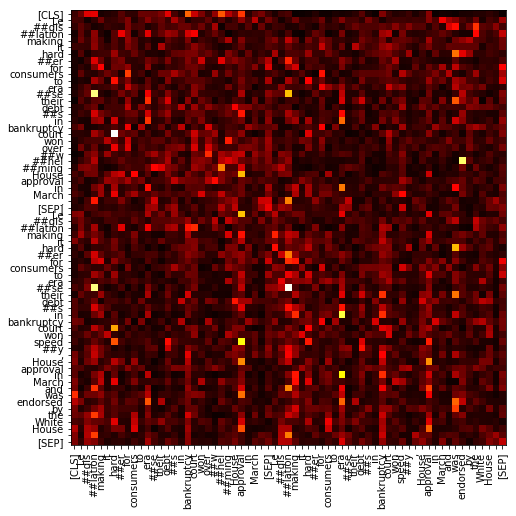

[[0.01159807 0.02041678 0.04429938 ... 0.00901423 0.00618261 0.00184228]
 [0.013019   0.01260779 0.00331447 ... 0.01313765 0.00987616 0.030668  ]
 [0.00935632 0.0179629  0.0111542  ... 0.01516151 0.02658444 0.01247476]
 ...
 [0.0347777  0.00796157 0.03344547 ... 0.01662819 0.00735681 0.01227832]
 [0.02520917 0.00517662 0.03513214 ... 0.02108385 0.03045251 0.01742806]
 [0.02427493 0.00959927 0.02917441 ... 0.02585948 0.01981904 0.03770486]]


In [26]:
attention_map(probs, token_list, 0, 9, 5)

In [27]:
import networkx as nx
from networkx.algorithms import bipartite

In [36]:
def nx_attention_graph(probs, token_list, sentence_id, layer, head):
    seq_len = len(token_list[sentence_id])
    biadjacency = probs[sentence_id, layer, head, :seq_len, :seq_len]
    
    B = nx.Graph()
    labeldict = {}
    for i in range(seq_len):
        labeldict[i] = labeldict[i+seq_len] = token_list[sentence_id][i]
        B.add_node(i, bipartite = 0)
        B.add_node(i+seq_len, bipartite = 1)
    
    for i in range(seq_len):
        for j in range(seq_len):
            B.add_edge(i, j+seq_len, weight=biadjacency[i,j])
            
    edges, weights = zip(*nx.get_edge_attributes(B,'weight').items())
    
            
            
    l, r = nx.bipartite.sets(B)
    pos = {}

    # Update position for node from each group
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))

    plt.figure(figsize = (18,30))
#     nx.draw(B, pos=pos, labels=labeldict, with_labels = True, edge_color = weights, edge_cmap=plt.cm.Blues)
    nx.draw(B, pos=pos, labels=labeldict, with_labels = True, edgelist=edges, edge_color=weights, width=0.5, edge_cmap=plt.cm.Blues)
    
    plt.show()

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64} {128, 129, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127} 65


/home/santhosh/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/santhosh/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/santhosh/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/santhosh/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

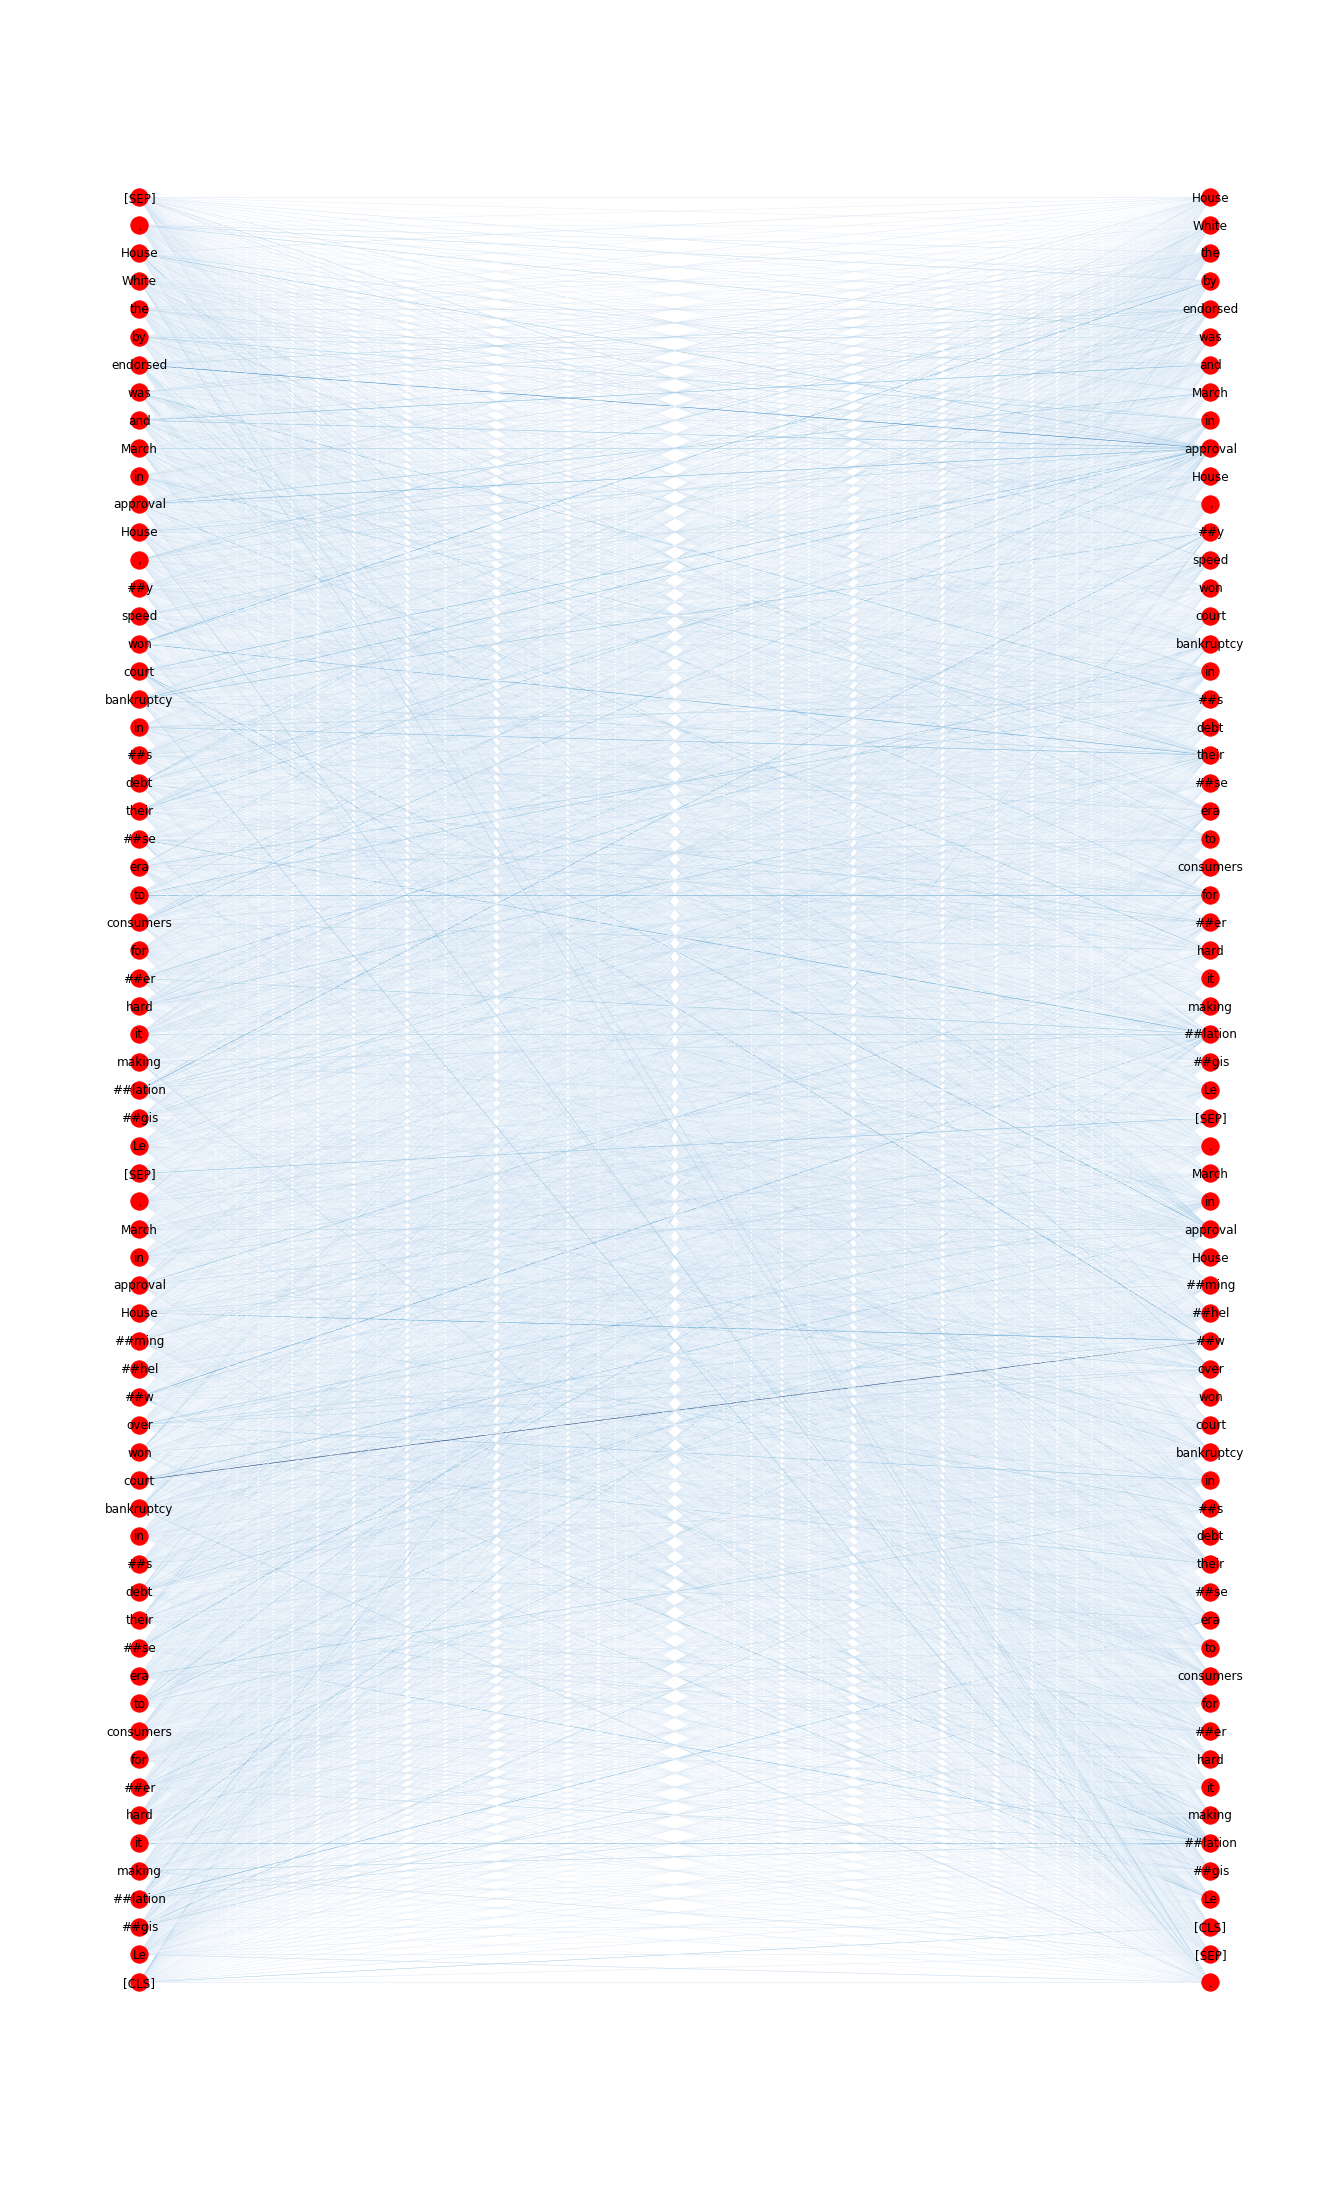

In [37]:
nx_attention_graph(probs, token_list, 0, 8, 11)

/home/santhosh/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/santhosh/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/santhosh/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/santhosh/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axe

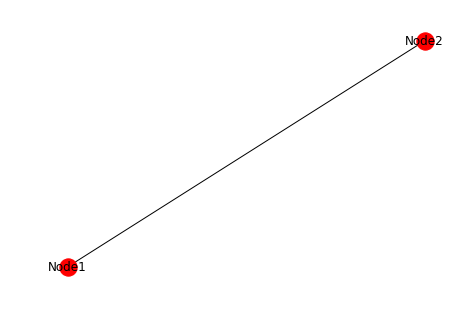

In [30]:
import networkx as nx
import pylab as plt
import matplotlib.pyplot as plt

G=nx.Graph()
# Add nodes and edges
G.add_edge("Node1", "Node2")
nx.draw(G, with_labels = True)
plt.show()